*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.3
IPython 6.2.1

tensorflow 1.5.0-rc1


# Model Zoo -- Autoencoder

A simple, single-layer autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations).

In [2]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np


##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.005
num_epochs = 5
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 32

# Other
random_seed = 123


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [3]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.data.normal_(0.0, 0.1)
        self.linear_1.bias.data.zero_()
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = F.sigmoid(logits)
        
        return decoded

    
torch.manual_seed(0)
model = Autoencoder(num_features=num_features)

if torch.cuda.is_available():
    model.cuda()
    

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.BCELoss() # torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [4]:
from torch.autograd import Variable
   

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = Variable(features.view(-1, 28*28))

        if torch.cuda.is_available():
            features, targets = features.cuda(), targets.cuda()
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost.data[0]))

Epoch: 001/005 | Batch 000/468 | Cost: 0.7287
Epoch: 001/005 | Batch 050/468 | Cost: 0.2095
Epoch: 001/005 | Batch 100/468 | Cost: 0.1683
Epoch: 001/005 | Batch 150/468 | Cost: 0.1431
Epoch: 001/005 | Batch 200/468 | Cost: 0.1288
Epoch: 001/005 | Batch 250/468 | Cost: 0.1205
Epoch: 001/005 | Batch 300/468 | Cost: 0.1170
Epoch: 001/005 | Batch 350/468 | Cost: 0.1096
Epoch: 001/005 | Batch 400/468 | Cost: 0.1096
Epoch: 001/005 | Batch 450/468 | Cost: 0.1061
Epoch: 002/005 | Batch 000/468 | Cost: 0.1036
Epoch: 002/005 | Batch 050/468 | Cost: 0.1047
Epoch: 002/005 | Batch 100/468 | Cost: 0.1000
Epoch: 002/005 | Batch 150/468 | Cost: 0.0975
Epoch: 002/005 | Batch 200/468 | Cost: 0.0956
Epoch: 002/005 | Batch 250/468 | Cost: 0.0975
Epoch: 002/005 | Batch 300/468 | Cost: 0.0923
Epoch: 002/005 | Batch 350/468 | Cost: 0.0909
Epoch: 002/005 | Batch 400/468 | Cost: 0.0972
Epoch: 002/005 | Batch 450/468 | Cost: 0.0987
Epoch: 003/005 | Batch 000/468 | Cost: 0.0950
Epoch: 003/005 | Batch 050/468 | C

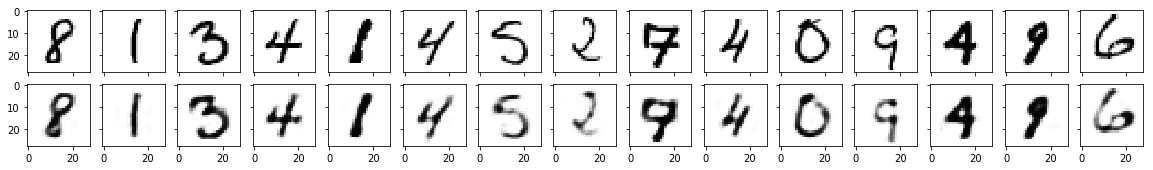

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((image_width, image_width)), cmap='binary')